In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


In [2]:
X = np.load('/home/dima/Data/sentiment_data_x.npy')
Y = np.load('/home/dima/Data/sentiment_data_y.npy')
X_test = X[20000:,:]
Y_test = Y[20000:,:]
X = X[:20000,:]
Y = Y[:20000,:]
print 'X shape: ' + str(X.shape)
print 'Y shape: ' + str(Y.shape)

X shape: (20000, 42)
Y shape: (20000, 3)


In [3]:
np.mean(Y[:,2])

0.21265000000000001

In [4]:
vocab = np.load('/home/dima/Data/sentiment_vocab.npy')
len(vocab)

21656

In [5]:
vocab_size = len(vocab)
embedding_size = 300
sequence_size = X.shape[1]
num_classes = Y.shape[1]

print vocab_size, embedding_size, sequence_size, num_classes

21656 300 42 3


In [6]:
input_x = tf.placeholder(tf.int32, [None, sequence_size], name="input_x")
input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")

In [7]:
W_embed = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W_embed")
embed_chars = tf.nn.embedding_lookup(W_embed, input_x)
embed_chars_expanded = tf.expand_dims(embed_chars, -1)

In [8]:

    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')

    def max_pool(x):
        return tf.nn.max_pool(x, [1, 41, 1, 1], strides=[1,1,1,1], padding='VALID')


    def add_filter(num_of_words):
        W_conv = weight_variable([num_of_words,embedding_size,1,10])
        b_conv = bias_variable([10])
        h_conv = tf.nn.relu(conv2d(embed_chars_expanded, W_conv) + b_conv)
        h_pool = max_pool(h_conv)

        return h_pool, h_conv, W_conv

In [9]:
filter = add_filter(2)
h_conv = filter[1]
W_conv = filter[2]


h_pool = tf.concat(3, [filter[0]])
h_pool_flat = tf.reshape(h_pool, [-1, 10])


In [10]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())


to_run = [embed_chars, embed_chars_expanded, W_conv, h_conv, h_pool, h_pool_flat]
result =  sess.run(to_run, feed_dict={input_x:X[:20], input_y:Y[:20]})

print 'embed_chars: %s' % str(result[0].shape)
print 'embed_chars_expanded: %s' % str(result[1].shape)
print 'W_conv: %s' % str(result[2].shape)
print 'h_conv: %s' % str(result[3].shape)
print 'h_pool: %s' % str(result[4].shape)
print 'h_pool_flat: %s' % str(result[5].shape)



embed_chars: (20, 42, 300)
embed_chars_expanded: (20, 42, 300, 1)
W_conv: (2, 300, 1, 10)
h_conv: (20, 41, 1, 10)
h_pool: (20, 1, 1, 10)
h_pool_flat: (20, 10)


In [11]:
fc_W = tf.Variable(tf.truncated_normal([10, 3], stddev=0.1), name="fc_W")
fc_b = tf.Variable(tf.constant(0.1, shape=[3]), name="fc_b")
scores = tf.nn.xw_plus_b(h_pool_flat, fc_W, fc_b)
predictions = tf.argmax(scores, 1)
correct_predictions = tf.argmax(input_y,1)

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7ff3046ec290>> ignored


100 step 100, training accuracy 0.393
200 step 200, training accuracy 0.5435
300 step 300, training accuracy 0.643
400 step 400, training accuracy 0.66825
500 step 500, training accuracy 0.6835
600 step 600, training accuracy 0.69475
700 step 700, training accuracy 0.72875
800 step 800, training accuracy 0.73725
900 step 900, training accuracy 0.75625
1000 step 1000, training accuracy 0.76725

test accuracy 0.69036
1100 step 1100, training accuracy 0.78725
1200 step 1200, training accuracy 0.7995
1300 step 1300, training accuracy 0.808
1400 step 1400, training accuracy 0.82275
1500 step 1500, training accuracy 0.82625
1600 step 1600, training accuracy 0.84875
1700 step 1700, training accuracy 0.8395
1800 step 1800, training accuracy 0.853
1900 step 1900, training accuracy 0.8615
2000 step 2000, training accuracy 0.86625

test accuracy 0.713242
2100 step 2100, training accuracy 0.88275
2200 step 2200, training accuracy 0.888
2300 step 2300, training accuracy 0.87725
2400 step 2400, trai

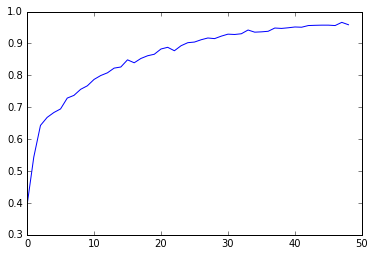

In [14]:
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(correct_predictions * tf.log(predictions), reduction_indices=[1]))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(scores,input_y)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
count_correct_prediction = tf.equal(predictions, correct_predictions)
accuracy = tf.reduce_mean(tf.cast(count_correct_prediction, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
accs = []
batch_size = 4000
for i in range(5000):
  print '\r' + str(i),
  #batch_x = X[i*batch_size:i*batch_size+batch_size,:]
  #batch_y = Y[i*batch_size:i*batch_size+batch_size,:
  
  ind = np.random.randint(len(X), size=batch_size)
  batch_x = X[ind]
  batch_y = Y[ind]

  if i%100 == 0 and i > 0:
    #print str(i*batch_size) + ':' + str(i*batch_size+batch_size) +' - ' + str(len(batch_x))
    train_accuracy = accuracy.eval(feed_dict={input_x:batch_x, input_y: batch_y})
    print("step %d, training accuracy %g"%(i, train_accuracy))
    accs.append(train_accuracy)
    
    if i%1000 ==0 and i > 0: print("\ntest accuracy %g"%accuracy.eval(feed_dict={input_x : X_test, input_y: Y_test}))
    
  train_step.run(feed_dict={input_x: batch_x, input_y : batch_y})

print("\ntest accuracy %g"%accuracy.eval(feed_dict={
   input_x : X_test, input_y: Y_test}))

plt.plot(accs)

In [15]:
saver = tf.train.Saver()